# OAK-D Camera Experiments

In [8]:
import depthai as dai
import numpy as np
import cv2
import time
import math
from pathlib import Path
from matplotlib import pyplot as plt
from collections import deque

## 1. Camera latency measurement

### Color

[44.092 26.962 26.945 26.677 27.465 26.686 26.747 26.905 26.859 26.95
 26.987 27.256]
Latency : Average : 28.38 ms, Std: 4.74 ms
Period (Frequency) : Average : 29.15 ms (34.30 Hz), Std: 9.97 ms
Frame shape : (152, 270, 3)


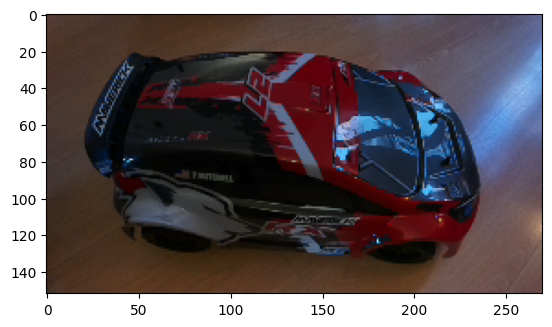

In [85]:
framerate = 30
ispScale = (8, 57) #(8, 57)  (1, 12)
resolution = (270, 152) # (270, 152)  (160, 90)

# Create pipeline
pipeline = dai.Pipeline()
# This might improve reducing the latency on some systems
pipeline.setXLinkChunkSize(0)

# Define output
xout = pipeline.create(dai.node.XLinkOut)
xout.setStreamName("xout")

# Define source and output
camera = pipeline.create(dai.node.ColorCamera)
camera.setResolution(dai.ColorCameraProperties.SensorResolution.THE_1080_P)
camera.setInterleaved(False)
camera.setColorOrder(dai.ColorCameraProperties.ColorOrder.RGB)
# see https://docs.google.com/spreadsheets/d/153yTstShkJqsPbkPOQjsVRmM8ZO3A6sCqm7uayGF-EE/edit#gid=0
camera.setIspScale(ispScale)
camera.setPreviewKeepAspectRatio(False)
camera.setPreviewSize(resolution) # wich means cropping if aspect ratio kept

# Link
camera.preview.link(xout.input)

# Common settings
camera.initialControl.setManualFocus(0) # from calibration data
camera.initialControl.setAutoWhiteBalanceMode(dai.CameraControl.AutoWhiteBalanceMode.FLUORESCENT) # CLOUDY_DAYLIGHT FLUORESCENT
camera.setFps(framerate)

# Connect to device and start pipeline
with dai.Device(pipeline) as device:
    # print('Connected cameras:', device.getConnectedCameras())
    # print('Usb speed:', device.getUsbSpeed().name)
    # if device.getBootloaderVersion() is not None:
    #     print('Bootloader version:', device.getBootloaderVersion())
    # print('Device name:', device.getDeviceName())
    
    queue = device.getOutputQueue(name="xout", maxSize=1, blocking=False)

    # wait for auto white balance to adjust
    time.sleep(2)

    latencies = deque([], maxlen=10)
    periods = deque([], maxlen=10)
    last = dai.Clock.now()

    count = 12
    while count > 0:
        data = queue.get()
        frame = data.getFrame()
        count -= 1

        now = dai.Clock.now()
        duration = (now - data.getTimestamp()).total_seconds() * 1000
        latencies = np.append(latencies, duration)
        
        duration = (now - last).total_seconds() * 1000
        periods = np.append(periods, duration)
        
        last = now

print(latencies)
print('Latency : Average : {:.2f} ms, Std: {:.2f} ms'.format(np.average(latencies), np.std(latencies)))
print('Period (Frequency) : Average : {:.2f} ms ({:.2f} Hz), Std: {:.2f} ms'.format(np.average(periods),
    1000 / np.average(periods), np.std(periods)))

frame = np.ascontiguousarray(frame.reshape((3, resolution[1], resolution[0])).transpose(1, 2, 0).astype(np.uint8))
print("Frame shape : " + str(frame.shape))
plt.imshow(frame)
plt.show()

### Mono

[12.075  8.546  9.132  8.453  8.354  8.339  8.479  8.451  8.36   8.366
  8.305  8.381]
Latency : Average : 8.77 ms, Std: 1.02 ms
Period (Frequency) : Average : 8.87 ms (112.69 Hz), Std: 2.84 ms
Frame shape : (152, 270, 1)


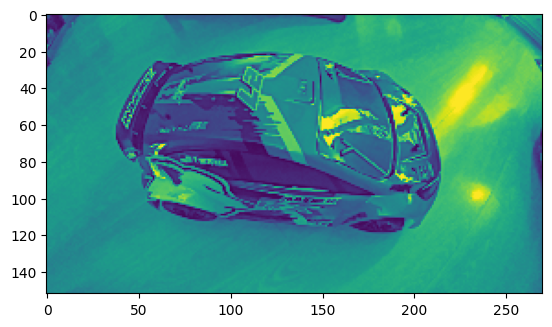

In [87]:
framerate = 100
resolution = (270, 152) # (160, 100) (640, 400)

# Create pipeline
pipeline = dai.Pipeline()
# This might improve reducing the latency on some systems
pipeline.setXLinkChunkSize(0)

# Define output
xout = pipeline.create(dai.node.XLinkOut)
xout.setStreamName("xout")

# Define source and output
camera = pipeline.create(dai.node.MonoCamera)
camera.setBoardSocket(dai.CameraBoardSocket.LEFT)
camera.setResolution(dai.MonoCameraProperties.SensorResolution.THE_400_P)

# Resize image
manip = pipeline.create(dai.node.ImageManip)
manip.setMaxOutputFrameSize(resolution[0] * resolution[1])
manip.initialConfig.setResize(resolution)
manip.initialConfig.setFrameType(dai.RawImgFrame.Type.GRAY8)

# Link
camera.out.link(manip.inputImage)
manip.out.link(xout.input)
# camera.out.link(xout.input)

# Common settings
camera.initialControl.setManualFocus(0) # from calibration data
camera.initialControl.setAutoWhiteBalanceMode(dai.CameraControl.AutoWhiteBalanceMode.FLUORESCENT) # CLOUDY_DAYLIGHT FLUORESCENT
camera.setFps(framerate)

# Connect to device and start pipeline
with dai.Device(pipeline) as device:
    # print('Connected cameras:', device.getConnectedCameras())
    # print('Usb speed:', device.getUsbSpeed().name)
    # if device.getBootloaderVersion() is not None:
    #     print('Bootloader version:', device.getBootloaderVersion())
    # print('Device name:', device.getDeviceName())

    queue = device.getOutputQueue(name="xout", maxSize=1, blocking=False)

    # wait for auto white balance to adjust
    time.sleep(2)

    latencies = deque([], maxlen=10)
    periods = deque([], maxlen=10)
    last = dai.Clock.now()

    count = 12
    while count > 0:
        data = queue.get()
        frame = data.getFrame()
        count -= 1

        now = dai.Clock.now()
        duration = (now - data.getTimestamp()).total_seconds() * 1000
        latencies = np.append(latencies, duration)
        
        duration = (now - last).total_seconds() * 1000
        periods = np.append(periods, duration)
        
        last = now

print(latencies)
print('Latency : Average : {:.2f} ms, Std: {:.2f} ms'.format(np.average(latencies), np.std(latencies)))
print('Period (Frequency) : Average : {:.2f} ms ({:.2f} Hz), Std: {:.2f} ms'.format(np.average(periods),
    1000 / np.average(periods), np.std(periods)))

frame = np.ascontiguousarray(frame.reshape((1, resolution[1], resolution[0])).transpose(1, 2, 0).astype(np.uint8))
print("Frame shape : " + str(frame.shape))
plt.imshow(frame)
plt.show()